# this notebook is to demultiplex the feature barcode to cell/barcode using scanpy demux function

In [2]:
import numpy as np
import scanpy as sc
import scipy
from scipy.sparse import csr_matrix
import anndata
import scanpy.external as sce
import time
import logging
import pandas as pd
import patsy
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
%matplotlib inline 
import tqdm as notebook_tqdm
import anndata
from composition_stats import clr

In [44]:
#path = '/data3/cyster/cr_outs/Control/outs/per_sample_outs/Control/count/sample_filtered_feature_bc_matrix/'
#path = "lib_run_1/outs/per_sample_outs/lib_run_1/count/sample_filtered_feature_bc_matrix"
path = "lib_3/outs/per_sample_outs/lib_3/count/sample_filtered_feature_bc_matrix"
#set gex_only to False to read in the feature barcoding data
ctrl = sc.read_10x_mtx(path, var_names='gene_symbols', cache=True, gex_only = False) 
ctrl # I think this needs to be redone, so we can make sure things were done right

AnnData object with n_obs × n_vars = 29546 × 36750
    var: 'gene_ids', 'feature_types'

In [45]:
ctrl.write_h5ad("h5ads/lib_3.h5ad")
#!ls lib_1/outs/per_sample_outs/lib_1/count/sample_filtered_feature_bc_matrix/matrix.mtx.gz

In [82]:
!ls -lh h5ads

total 4.0G
-rw-r----- 1 root root 545M Jun 12 10:08 lib_1.h5ad
-rw-r----- 1 root root 330M Jun 14 11:30 lib_1_after_hash_solo.h5ad
-rw-r----- 1 root root 330M Jun 14 13:08 lib_1_after_scrub.h5ad
-rw-r----- 1 root root 539M Jun 14 13:11 lib_2.h5ad
-rw-r----- 1 root root 321M Jun 14 13:17 lib_2_after_hash_solo.h5ad
-rw-r----- 1 root root 321M Jun 14 13:19 lib_2_after_scrub.h5ad
-rw-r----- 1 root root 529M Jun 14 13:14 lib_3.h5ad
-rw-r----- 1 root root 316M Jun 14 13:21 lib_3_after_hash_solo.h5ad
-rw-r----- 1 root root 316M Jun 14 13:23 lib_3_after_scrub.h5ad
-rw-r----- 1 root root 543M Jun 10 13:39 lib_run_1.h5ad


In [49]:

ctrl = sc.read_h5ad("h5ads/lib_3.h5ad")
# read it in, split it into separate RNA and protein anndata objects
# rna = ctrl[:, ctrl.var[:-149].index]
# prot = ctrl[:, ctrl.var[-149:-12].index]
# hashtags = ctrl[:, ctrl.var[-12:].index]
#print(rna, prot, hashtags)

View of AnnData object with n_obs × n_vars = 29546 × 36601
    var: 'gene_ids', 'feature_types' View of AnnData object with n_obs × n_vars = 29546 × 137
    var: 'gene_ids', 'feature_types' View of AnnData object with n_obs × n_vars = 29546 × 12
    var: 'gene_ids', 'feature_types'


In [5]:
ctrl.var[-150:]

,gene_ids,feature_types
AC007325.2,ENSG00000277196,Gene Expression
Hu.CD101,ADT_C0944,Antibody Capture
Hu.CD103,ADT_C0145,Antibody Capture
Hu.CD105_43A3,ADT_C0068,Antibody Capture
Hu.CD107a,ADT_C0155,Antibody Capture
...,...,...
TotalSeq-C0258 anti-human Hashtag 8 Antibody,8,Antibody Capture
TotalSeq-C0259 anti-human Hashtag 9 Antibody,9,Antibody Capture
TotalSeq-C0260 anti-human Hashtag 10 Antibody,10,Antibody Capture
TotalSeq-C0262 anti-human Hashtag 12 Antibody,12,Antibody Capture


In [46]:
hashtags.X

<29546x12 sparse matrix of type '<class 'numpy.float32'>'
	with 344048 stored elements in Compressed Sparse Row format>

In [66]:
ctrl.X[:, -12:]

<29546x12 sparse matrix of type '<class 'numpy.float32'>'
	with 344048 stored elements in Compressed Sparse Row format>

In [52]:
# Create hashsolo input 
# this is unlikely to be good enough here, read hashsolo paper
def over_input(dataframe, hashtag_names): #Hashtag names must be a list
    df_hash = pd.DataFrame(columns=dataframe.var_names, index=dataframe.obs.index)
    res = np.array(dataframe.X.todense()) # this step is very wasteful
    # it makes no difference, but hashsolo says to do all QC before running it, move things up 
    #clr(np.array(dataframe.X.todense()) + 1)#clr transform the hto, doesn't this transform everything? Yes!
    df_hash.iloc[:,:] = res
    dataframe.obs = df_hash.loc[:, hashtag_names]
    for i in hashtag_names: 
        dataframe.obs[i]=dataframe.obs[i].astype(float).astype(np.int64)
    return dataframe

In [58]:
# now we sub ctrl with prot
names = ctrl.var_names #hashtag_names 
#print(prot.X[:, -12:])
#print(names[-12:])

# what if we skip this normalization until after hash solo?
#raise error
ctrl_df = over_input(ctrl, names[-12:]) # there are negatives in here now?? -- there's definitely some weird stu
ctrl_df

AnnData object with n_obs × n_vars = 29546 × 36750
    obs: 'TotalSeq-C0251 anti-human Hashtag 1 Antibody', 'TotalSeq-C0252 anti-human Hashtag 2 Antibody', 'TotalSeq-C0253 anti-human Hashtag 3 Antibody', 'TotalSeq-C0254 anti-human Hashtag 4 Antibody', 'TotalSeq-C0255 anti-human Hashtag 5 Antibody', 'TotalSeq-C0256 anti-human Hashtag 6 Antibody', 'TotalSeq-C0257 anti-human Hashtag 7 Antibody', 'TotalSeq-C0258 anti-human Hashtag 8 Antibody', 'TotalSeq-C0259 anti-human Hashtag 9 Antibody', 'TotalSeq-C0260 anti-human Hashtag 10 Antibody', 'TotalSeq-C0262 anti-human Hashtag 12 Antibody', 'TotalSeq-C0263 anti-human Hashtag 13 Antibody'
    var: 'gene_ids', 'feature_types'

In [59]:
ctrl_df.obs

,TotalSeq-C0251 anti-human Hashtag 1 Antibody,TotalSeq-C0252 anti-human Hashtag 2 Antibody,TotalSeq-C0253 anti-human Hashtag 3 Antibody,TotalSeq-C0254 anti-human Hashtag 4 Antibody,TotalSeq-C0255 anti-human Hashtag 5 Antibody,TotalSeq-C0256 anti-human Hashtag 6 Antibody,TotalSeq-C0257 anti-human Hashtag 7 Antibody,TotalSeq-C0258 anti-human Hashtag 8 Antibody,TotalSeq-C0259 anti-human Hashtag 9 Antibody,TotalSeq-C0260 anti-human Hashtag 10 Antibody,TotalSeq-C0262 anti-human Hashtag 12 Antibody,TotalSeq-C0263 anti-human Hashtag 13 Antibody
AAACCTGAGAACAATC-1,12,17,9,632,10,6,30,11,10,7,1,3
AAACCTGAGAACTGTA-1,7,4,0,529,6,5,3,4,2,1,1,3
AAACCTGAGACGACGT-1,15,40,11,8,10,11,20,13,277,7,3,9
AAACCTGAGACGCTTT-1,10,10,12,6,7,1278,12,4,11,9,0,1
AAACCTGAGACTGTAA-1,5,6,5,2,7,2,9,6,571,4,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCCGCGTTT-1,4,1,5,2,8,7,438,5,5,1,0,2
TTTGTCATCCTACAGA-1,6,9,954,0,7,1,7,3,5,3,1,2
TTTGTCATCCTAGTGA-1,7,315,13,564,2,18,6,5,5,7,3,3
TTTGTCATCGTCTGCT-1,18,10,6,16,1524,6,21,8,15,12,8,5


In [60]:
sce.pp.hashsolo(ctrl_df, list(ctrl_df.obs.columns))

Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


In [61]:
print(ctrl_df.obs.Classification.value_counts()) # no difference!!!!!!!

Classification
Doublet                                          9630
TotalSeq-C0255 anti-human Hashtag 5 Antibody     2714
TotalSeq-C0251 anti-human Hashtag 1 Antibody     2655
TotalSeq-C0259 anti-human Hashtag 9 Antibody     2418
TotalSeq-C0257 anti-human Hashtag 7 Antibody     1690
TotalSeq-C0260 anti-human Hashtag 10 Antibody    1598
TotalSeq-C0254 anti-human Hashtag 4 Antibody     1571
TotalSeq-C0253 anti-human Hashtag 3 Antibody     1561
TotalSeq-C0256 anti-human Hashtag 6 Antibody     1380
TotalSeq-C0252 anti-human Hashtag 2 Antibody     1379
TotalSeq-C0262 anti-human Hashtag 12 Antibody    1029
TotalSeq-C0258 anti-human Hashtag 8 Antibody     1017
TotalSeq-C0263 anti-human Hashtag 13 Antibody     767
Negative                                          137
Name: count, dtype: int64


In [62]:
# calc the doublet rate per sample --report (doublet / total_number)
doublet_rate = ctrl_df.obs.Classification.value_counts()["Doublet"] / len(ctrl_df.obs.index)
doublet_rate

0.3259324443241048

In [73]:
# remove negs and doublets
cleaned_df = ctrl_df[~ctrl_df.obs['Classification'].isin(['Doublet', 'Negative'])]
cleaned_df.obs.index

Index(['AAACCTGAGAACAATC-1', 'AAACCTGAGAACTGTA-1', 'AAACCTGAGACGACGT-1',
       'AAACCTGAGACGCTTT-1', 'AAACCTGAGACTGTAA-1', 'AAACCTGAGAGCCCAA-1',
       'AAACCTGAGATCCGAG-1', 'AAACCTGAGATCTGCT-1', 'AAACCTGAGATGCGAC-1',
       'AAACCTGAGCATCATC-1',
       ...
       'TTTGTCAGTCTGATCA-1', 'TTTGTCAGTGAAAGAG-1', 'TTTGTCAGTGAGTATA-1',
       'TTTGTCAGTGTGGCTC-1', 'TTTGTCATCACGATGT-1', 'TTTGTCATCATTGCCC-1',
       'TTTGTCATCCGCGTTT-1', 'TTTGTCATCCTACAGA-1', 'TTTGTCATCGTCTGCT-1',
       'TTTGTCATCTTGGGTA-1'],
      dtype='object', length=20284)

In [74]:
# now I need to reassign with the Thaw IDs-- just apply a dict to change it (add metadeta)
# save it before next step
hashtag_to_thaw = {
    "TotalSeq-C0251 anti-human Hashtag 1 Antibody" : "M-A3-Unsti",
    "TotalSeq-C0255 anti-human Hashtag 5 Antibody" : "U-A3-Unsti", 
    "TotalSeq-C0259 anti-human Hashtag 9 Antibody" : "Z-A3-Unsti",  
    "TotalSeq-C0253 anti-human Hashtag 3 Antibody" : "M-A3-6th",    
    "TotalSeq-C0254 anti-human Hashtag 4 Antibody" : "M-A3-9th",  
    "TotalSeq-C0257 anti-human Hashtag 7 Antibody" : "U-A3-7th",
    "TotalSeq-C0260 anti-human Hashtag 10 Antibody": "Z-A3-1st",
    "TotalSeq-C0252 anti-human Hashtag 2 Antibody" : "M-A3-3rd",
    "TotalSeq-C0256 anti-human Hashtag 6 Antibody" : "U-A3-4th",
    "TotalSeq-C0258 anti-human Hashtag 8 Antibody" : "U-A3-10th",
    "TotalSeq-C0262 anti-human Hashtag 12 Antibody": "Z-A3-5th",
    "TotalSeq-C0263 anti-human Hashtag 13 Antibody": "Z-A3-9th"
} # want to cluster by donor, which is letter; then within donor, cluster by timepoint
# mapping to cell fate: ask George, Elisabeth (but with 3 prime CITEseq)
# also make an overall umap
# make a umap for each donor at each timepoint
# make a umap for all timepoints for a donor
# align to a database of possible cell fates last
# do separate clusters first, then get MM clusters
# do this with muon, do multimodal alignment with weighted nearest neighbors
# all should be T cells, panel of proteins should be depleted for PBMCs
cleaned_df.obs["Thaw"] = cleaned_df.obs['Classification'].map(hashtag_to_thaw)
cleaned_df.obs

/tmp/ipykernel_135223/2306947710.py:17: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  cleaned_df.obs["Thaw"] = cleaned_df.obs['Classification'].map(hashtag_to_thaw)


,TotalSeq-C0251 anti-human Hashtag 1 Antibody,TotalSeq-C0252 anti-human Hashtag 2 Antibody,TotalSeq-C0253 anti-human Hashtag 3 Antibody,TotalSeq-C0254 anti-human Hashtag 4 Antibody,TotalSeq-C0255 anti-human Hashtag 5 Antibody,TotalSeq-C0256 anti-human Hashtag 6 Antibody,TotalSeq-C0257 anti-human Hashtag 7 Antibody,TotalSeq-C0258 anti-human Hashtag 8 Antibody,TotalSeq-C0259 anti-human Hashtag 9 Antibody,TotalSeq-C0260 anti-human Hashtag 10 Antibody,TotalSeq-C0262 anti-human Hashtag 12 Antibody,TotalSeq-C0263 anti-human Hashtag 13 Antibody,most_likely_hypothesis,cluster_feature,negative_hypothesis_probability,singlet_hypothesis_probability,doublet_hypothesis_probability,Classification,Thaw
AAACCTGAGAACAATC-1,2,2,2,6,2,1,3,2,2,2,0,1,1.0,0.0,3.298834e-06,0.999987,9.328603e-06,TotalSeq-C0254 anti-human Hashtag 4 Antibody,M-A3-9th
AAACCTGAGAACTGTA-1,2,1,0,6,1,1,1,1,1,0,0,1,1.0,0.0,4.202768e-06,0.999996,8.829900e-14,TotalSeq-C0254 anti-human Hashtag 4 Antibody,M-A3-9th
AAACCTGAGACGACGT-1,2,3,2,2,2,2,3,2,5,2,1,2,1.0,0.0,1.012686e-04,0.999889,9.327689e-06,TotalSeq-C0259 anti-human Hashtag 9 Antibody,Z-A3-Unsti
AAACCTGAGACGCTTT-1,2,2,2,1,2,7,2,1,2,2,0,0,1.0,0.0,8.655365e-07,0.999999,1.402026e-10,TotalSeq-C0256 anti-human Hashtag 6 Antibody,U-A3-4th
AAACCTGAGACTGTAA-1,1,1,1,1,2,1,2,1,6,1,0,0,1.0,0.0,3.959908e-06,0.999996,3.997353e-13,TotalSeq-C0259 anti-human Hashtag 9 Antibody,Z-A3-Unsti
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCATTGCCC-1,0,1,1,1,5,1,1,1,1,1,0,1,1.0,0.0,1.755375e-05,0.999982,4.222565e-16,TotalSeq-C0255 anti-human Hashtag 5 Antibody,U-A3-Unsti
TTTGTCATCCGCGTTT-1,1,0,1,1,2,2,6,1,1,0,0,1,1.0,0.0,5.908008e-06,0.999994,3.281686e-16,TotalSeq-C0257 anti-human Hashtag 7 Antibody,U-A3-7th
TTTGTCATCCTACAGA-1,1,2,6,0,2,0,2,1,1,1,0,1,1.0,0.0,3.131994e-06,0.999997,3.997356e-13,TotalSeq-C0253 anti-human Hashtag 3 Antibody,M-A3-6th
TTTGTCATCGTCTGCT-1,2,2,1,2,7,1,3,2,2,2,2,1,1.0,0.0,2.174309e-06,0.999988,9.328614e-06,TotalSeq-C0255 anti-human Hashtag 5 Antibody,U-A3-Unsti


In [75]:
#save object -- need to save it as sparse
cleaned_df.write_h5ad('h5ads/lib_3_after_hash_solo.h5ad')

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.83
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.5%
Elapsed time: 30.3 seconds


(<Figure size 800x300 with 2 Axes>,
 array([<Axes: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <Axes: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

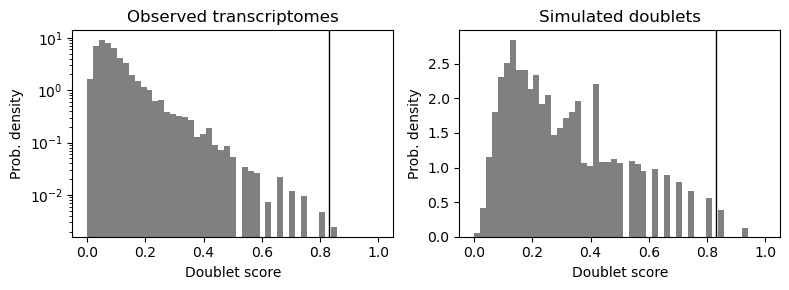

In [76]:
# then doublet removal with scrublet (again)
# this is very slow
# cleaned_df = sc.read_h5ad("h5ads/lib_1_after_hash_solo.h5ad")
# should be a raw UMI counts matrix as input
import scrublet as scr

scrub = scr.Scrublet(cleaned_df.X) # , expected_doublet_rate=0.06) need to check 10X
# the biggest problem seems to be getting this thing into sparse matrix format

doublet_scores, predicted_doublets = scrub.scrub_doublets()
scrub.plot_histogram()

(<Figure size 800x400 with 3 Axes>,
 array([<Axes: title={'center': 'Predicted doublets'}, xlabel='UMAP 1', ylabel='UMAP 2'>,
        <Axes: title={'center': 'Doublet score'}, xlabel='UMAP 1', ylabel='UMAP 2'>],
       dtype=object))

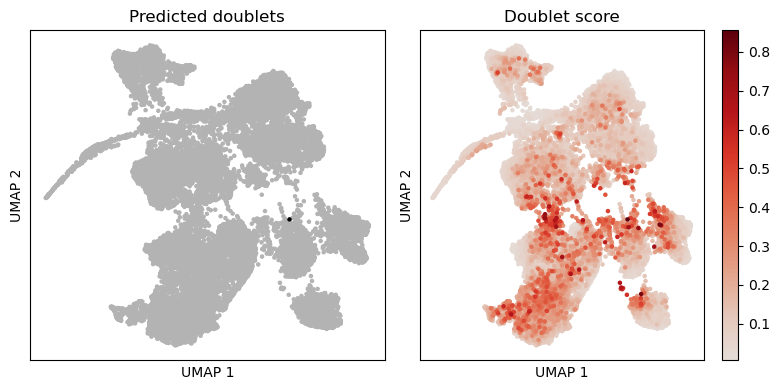

In [77]:
scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
scrub.plot_embedding('UMAP', order_points=True)

In [78]:
# now remove these doublets
predicted_doublets_z = scrub.call_doublets() #threshold=0.33)
#scrub.plot_histogram();

Automatically set threshold at doublet score = 0.83
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.5%


In [79]:
#len(scrub.predicted_doublets_)

# only 2 predicted doublets, remove them, then save again -- have this done for all 3 samples
#save object -- need to save it as sparse

cleaned_df[~scrub.predicted_doublets_].write_h5ad('h5ads/lib_3_after_scrub.h5ad')

In [15]:
import scanpy as sc
# load in each sample after scrub
file_list = [
     sc.read_h5ad('h5ads/lib_1_after_scrub.h5ad'), 
     sc.read_h5ad('h5ads/lib_2_after_scrub.h5ad'), 
     sc.read_h5ad('h5ads/lib_3_after_scrub.h5ad')
]


#rna_prot = [sc.read_csv("rna_counts.csv"),  sc.read_csv("protein_counts.csv")] this is what it was
# needs to be only the gene expression part of the adata object, clr was already applied to protein part
for adata in file_list:
    # elim all 0 zero count features
    sc.pp.filter_genes(adata, min_counts=1)
    # look at percent mito and ribo counts, and percent of total counts per cell
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.pct_counts_mt < 5, :]
    print(adata)
    raise Error
    # RNA seq normalization -- need to normalize
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    # basic dim reduction for each modality
    sc.pp.pca(adata)
    # batch correction
    sce.pp.harmony_integrate(adata, 'batch')
    # needs to be done for wnn step anyway
    sc.pp.neighbors(adata) 
    


View of AnnData object with n_obs × n_vars = 12421 × 26223
    obs: 'TotalSeq-C0251 anti-human Hashtag 1 Antibody', 'TotalSeq-C0252 anti-human Hashtag 2 Antibody', 'TotalSeq-C0253 anti-human Hashtag 3 Antibody', 'TotalSeq-C0254 anti-human Hashtag 4 Antibody', 'TotalSeq-C0255 anti-human Hashtag 5 Antibody', 'TotalSeq-C0256 anti-human Hashtag 6 Antibody', 'TotalSeq-C0257 anti-human Hashtag 7 Antibody', 'TotalSeq-C0258 anti-human Hashtag 8 Antibody', 'TotalSeq-C0259 anti-human Hashtag 9 Antibody', 'TotalSeq-C0260 anti-human Hashtag 10 Antibody', 'TotalSeq-C0262 anti-human Hashtag 12 Antibody', 'TotalSeq-C0263 anti-human Hashtag 13 Antibody', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'Thaw', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by

NameError: name 'Error' is not defined

In [ ]:
#names = ["rna", "protein"]
# then UMAP reduction
sc.tl.umap(rna_prot[i])
sc.tl.leiden(rna_prot[i], key_added=names[i]+"_leiden", resolution=0.1)
sc.pl.umap(rna_prot[i], color=names[i]+"_leiden", size=10)

In [ ]:
rna, protein = rna_prot

# If you want to show the difference in individual modality clustering
rna.obsm["protein"] = protein.to_df()
rna.obsm["protein_umap"] = protein.obsm["X_umap"]
rna.obs["protein_leiden"] = protein.obs["protein_leiden"]
rna.obsp["rna_connectivities"] = rna.obsp["connectivities"].copy()
protein.obsp["protein_connectivities"] = protein.obsp["connectivities"].copy()
rna.obsp["protein_connectivities"] = protein.obsp["protein_connectivities"]
sc.tl.umap(rna)
sc.pl.umap(rna, color=["rna_leiden", "protein_leiden"], size=10)
sc.pl.embedding(rna, basis="protein_umap", color=["rna_leiden", "protein_leiden"], size=10)

In [ ]:
mdata = mu.MuData({'rna': rna_prot[0], 'prot': rna_prot[1]})
# Calculate weighted nearest neighbors
mu.pp.neighbors(mdata, key_added='wnn')
mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)
mu.pl.umap(mdata, color=['rna:mod_weight', 'prot:mod_weight'], cmap='RdBu')
# actual joint clustering
sc.tl.leiden(mdata, resolution=0.1, neighbors_key='wnn', key_added='leiden_wnn') # 0.1 makes fewer clusters
sc.pl.umap(mdata, color='leiden_wnn', legend_loc='on data')

In [ ]:
labels = mdata.obs["leiden_wnn"] # here are the labels
rna = mdata["rna"] # normalized RNA counts
prot = mdata["prot"]
rna.obs["labels"] = labels
prot.obs["labels"] = labels
sc.tl.rank_genes_groups(rna, 'labels', method='wilcoxon', key_added = "wilcoxon") # wilcoxon rank sum, 'benjamini-hochberg' correction
# get top 3 genes
sc.pl.rank_genes_groups_heatmap(rna, n_genes=3, key="wilcoxon", groupby="labels", show_gene_labels=True)
# get top 3 prots
sc.tl.rank_genes_groups(prot, 'labels', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups_heatmap(prot, n_genes=3, key="wilcoxon", groupby="labels", show_gene_labels=True)

# rank important gene groups between clusters
# sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
# super impose clustering with actual hashtag labels